## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import copy

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[128, 64, 32]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    output_layer = keras.layers.Dense(units=output_units, 
                                      activation="softmax", 
                                      name="output_layer")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_list = ['SGD', 'Adam', 'RMSprop']
optimizer_set = {'SGD':keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 'Adam':keras.optimizers.Adam(lr=LEARNING_RATE),
                 'RMSprop':keras.optimizers.RMSprop(lr=LEARNING_RATE)}

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor =[0.5, 0.25]
redice_lr_patient = [3, 6]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_list, reduce_lr_factor, redice_lr_patient)):
    optim_lr_copy = copy.deepcopy(optimizer_set[optim].lr) # 備份learning rate，每一輪實驗都必須重置
    keras.backend.clear_session() # 把舊的 Graph 清掉    
    print("#"*50)
    print('optimizer:', optim)
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    print("#"*50)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer_set[optim])
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s_%s_%.2f_%d" % (i, optim, reduce_factor, reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}
    
    # reset optimizer learning rate
    optimizer_set[optim].learning_rate = copy.deepcopy(optim_lr_copy)

##################################################
optimizer: SGD
Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 3
##################################################
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
hidden_layer3 (D

Epoch 42/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.0978 - accuracy: 0.6131 - val_loss: 1.4340 - val_accuracy: 0.5025
Epoch 43/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.0998 - accuracy: 0.6106 - val_loss: 1.4364 - val_accuracy: 0.5024

Epoch 00043: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 44/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.0990 - accuracy: 0.6118 - val_loss: 1.4347 - val_accuracy: 0.5017
Epoch 45/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.0964 - accuracy: 0.6137 - val_loss: 1.4351 - val_accuracy: 0.5019
Epoch 46/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.0974 - accuracy: 0.6139 - val_loss: 1.4349 - val_accuracy: 0.5016

Epoch 00046: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 47/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.0980 - accuracy

50000/50000 [==============================] - 6s 110us/step - loss: 0.9968 - accuracy: 0.6448 - val_loss: 1.4866 - val_accuracy: 0.4938
Epoch 34/50
50000/50000 [==============================] - 5s 94us/step - loss: 0.9878 - accuracy: 0.6490 - val_loss: 1.5184 - val_accuracy: 0.4919
Epoch 35/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.9814 - accuracy: 0.6511 - val_loss: 1.5007 - val_accuracy: 0.4942
Epoch 36/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.9792 - accuracy: 0.6531 - val_loss: 1.5155 - val_accuracy: 0.4895
Epoch 37/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.9723 - accuracy: 0.6567 - val_loss: 1.5073 - val_accuracy: 0.4910
Epoch 38/50
50000/50000 [==============================] - 5s 92us/step - loss: 0.9691 - accuracy: 0.6572 - val_loss: 1.5213 - val_accuracy: 0.4879

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 39/50
50000/50000 [=================

50000/50000 [==============================] - 5s 93us/step - loss: 1.1946 - accuracy: 0.5767 - val_loss: 1.4249 - val_accuracy: 0.5016
Epoch 25/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.1940 - accuracy: 0.5769 - val_loss: 1.4243 - val_accuracy: 0.5030
Epoch 26/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.1941 - accuracy: 0.5771 - val_loss: 1.4254 - val_accuracy: 0.5014
Epoch 27/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.1927 - accuracy: 0.5789 - val_loss: 1.4245 - val_accuracy: 0.5014
Epoch 28/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.1920 - accuracy: 0.5780 - val_loss: 1.4241 - val_accuracy: 0.5023
Epoch 29/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.1925 - accuracy: 0.5787 - val_loss: 1.4261 - val_accuracy: 0.4985
Epoch 30/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.1910 - accuracy: 0.5801 - val_loss: 1.4247

50000/50000 [==============================] - 5s 92us/step - loss: 1.2883 - accuracy: 0.5443 - val_loss: 1.5171 - val_accuracy: 0.4664
Epoch 15/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.2715 - accuracy: 0.5508 - val_loss: 1.4958 - val_accuracy: 0.4698
Epoch 16/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.2553 - accuracy: 0.5566 - val_loss: 1.4979 - val_accuracy: 0.4694
Epoch 17/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.2415 - accuracy: 0.5620 - val_loss: 1.5357 - val_accuracy: 0.4560
Epoch 18/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.2271 - accuracy: 0.5670 - val_loss: 1.4929 - val_accuracy: 0.4712
Epoch 19/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.2121 - accuracy: 0.5711 - val_loss: 1.5133 - val_accuracy: 0.4749
Epoch 20/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.1949 - accuracy: 0.5785 - val_loss: 1.6074

50000/50000 [==============================] - 6s 115us/step - loss: 1.3393 - accuracy: 0.5216 - val_loss: 1.6126 - val_accuracy: 0.4267
Epoch 7/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.3094 - accuracy: 0.5325 - val_loss: 1.7978 - val_accuracy: 0.3840
Epoch 8/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.2786 - accuracy: 0.5461 - val_loss: 1.5746 - val_accuracy: 0.4476
Epoch 9/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.2593 - accuracy: 0.5493 - val_loss: 1.5563 - val_accuracy: 0.4536
Epoch 10/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.2335 - accuracy: 0.5605 - val_loss: 1.5290 - val_accuracy: 0.4663
Epoch 11/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.2123 - accuracy: 0.5677 - val_loss: 1.5318 - val_accuracy: 0.4591
Epoch 12/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.1985 - accuracy: 0.5712 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.7756 - accuracy: 0.3650 - val_loss: 1.7202 - val_accuracy: 0.3841
Epoch 2/50
50000/50000 [==============================] - 12s 231us/step - loss: 1.5735 - accuracy: 0.4387 - val_loss: 1.6286 - val_accuracy: 0.4268
Epoch 3/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4972 - accuracy: 0.4664 - val_loss: 1.5568 - val_accuracy: 0.4442
Epoch 4/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.4388 - accuracy: 0.4887 - val_loss: 1.5483 - val_accuracy: 0.4506
Epoch 5/50
50000/50000 [==============================] - 6s 111us/step - loss: 1.4003 - accuracy: 0.5010 - val_loss: 1.5468 - val_accuracy: 0.4473
Epoch 6/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.3662 - accuracy: 0.5134 - val_loss: 1.5441 - val_accuracy: 0.4530
Epoch 7/50
50000/50000 [==============================] - 6s 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.7897 - accuracy: 0.3643 - val_loss: 1.6877 - val_accuracy: 0.4003
Epoch 2/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.5823 - accuracy: 0.4383 - val_loss: 1.6157 - val_accuracy: 0.4252
Epoch 3/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.5013 - accuracy: 0.4676 - val_loss: 1.6829 - val_accuracy: 0.4058
Epoch 4/50
50000/50000 [==============================] - 6s 110us/step - loss: 1.4464 - accuracy: 0.4851 - val_loss: 1.5700 - val_accuracy: 0.4459
Epoch 5/50
50000/50000 [==============================] - 6s 127us/step - loss: 1.3993 - accuracy: 0.5018 - val_loss: 1.4881 - val_accuracy: 0.4755
Epoch 6/50
50000/50000 [==============================] - 5s 108us/step - loss: 1.3625 - accuracy: 0.5155 - val_loss: 1.5127 - val_accuracy: 0.4628
Epoch 7/50
50000/50000 [==============================] - 5s 10

Epoch 50/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.1445 - accuracy: 0.5925 - val_loss: 1.3837 - val_accuracy: 0.5155
##################################################
optimizer: Adam
Numbers of exp: 7, reduce_factor: 0.25, reduce_patient: 6
##################################################
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 128)               393344    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
hidden_layer2 (Dense)        (None, 64)                8256      
________________________________________________________________

Epoch 42/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.9853 - accuracy: 0.6503 - val_loss: 1.3975 - val_accuracy: 0.5193

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 43/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.9844 - accuracy: 0.6508 - val_loss: 1.3977 - val_accuracy: 0.5184
Epoch 44/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.9824 - accuracy: 0.6496 - val_loss: 1.3973 - val_accuracy: 0.5190
Epoch 45/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.9847 - accuracy: 0.6492 - val_loss: 1.3977 - val_accuracy: 0.5197
Epoch 46/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.9832 - accuracy: 0.6514 - val_loss: 1.3975 - val_accuracy: 0.5190
Epoch 47/50
50000/50000 [==============================] - 5s 106us/step - loss: 0.9820 - accuracy: 0.6518 - val_loss: 1.3977 - val_accuracy: 0.5188
Epoch 48/50
50000/50000 [

Epoch 32/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.0426 - accuracy: 0.6321 - val_loss: 1.4338 - val_accuracy: 0.5095
Epoch 33/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.0399 - accuracy: 0.6346 - val_loss: 1.4346 - val_accuracy: 0.5080

Epoch 00033: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 34/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.0394 - accuracy: 0.6320 - val_loss: 1.4355 - val_accuracy: 0.5095
Epoch 35/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.0396 - accuracy: 0.6329 - val_loss: 1.4347 - val_accuracy: 0.5095
Epoch 36/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.0380 - accuracy: 0.6345 - val_loss: 1.4363 - val_accuracy: 0.5099

Epoch 00036: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Epoch 37/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.0397 - accuracy:

50000/50000 [==============================] - 5s 94us/step - loss: 1.0709 - accuracy: 0.6248 - val_loss: 1.4941 - val_accuracy: 0.4872
Epoch 22/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.0619 - accuracy: 0.6266 - val_loss: 1.5490 - val_accuracy: 0.4772
Epoch 23/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.0568 - accuracy: 0.6253 - val_loss: 1.4904 - val_accuracy: 0.4916
Epoch 24/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.0493 - accuracy: 0.6297 - val_loss: 1.5174 - val_accuracy: 0.4858
Epoch 25/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.0433 - accuracy: 0.6308 - val_loss: 1.5417 - val_accuracy: 0.4872
Epoch 26/50
50000/50000 [==============================] - 5s 97us/step - loss: 1.0366 - accuracy: 0.6336 - val_loss: 1.4615 - val_accuracy: 0.5007
Epoch 27/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.0332 - accuracy: 0.6377 - val_loss: 1.5486

50000/50000 [==============================] - 6s 110us/step - loss: 1.1724 - accuracy: 0.5851 - val_loss: 1.4236 - val_accuracy: 0.4929
Epoch 13/50
50000/50000 [==============================] - 5s 103us/step - loss: 1.1636 - accuracy: 0.5868 - val_loss: 1.4583 - val_accuracy: 0.4846

Epoch 00013: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 14/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.1383 - accuracy: 0.5972 - val_loss: 1.3794 - val_accuracy: 0.5134
Epoch 15/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.1321 - accuracy: 0.5994 - val_loss: 1.3708 - val_accuracy: 0.5138
Epoch 16/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.1299 - accuracy: 0.6008 - val_loss: 1.3710 - val_accuracy: 0.5154
Epoch 17/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.1239 - accuracy: 0.6022 - val_loss: 1.3780 - val_accuracy: 0.5128
Epoch 18/50
50000/50000 [=================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.7754 - accuracy: 0.3783 - val_loss: 2.1886 - val_accuracy: 0.2655
Epoch 2/50
50000/50000 [==============================] - 5s 98us/step - loss: 1.5661 - accuracy: 0.4473 - val_loss: 2.2352 - val_accuracy: 0.2989
Epoch 3/50
50000/50000 [==============================] - 5s 96us/step - loss: 1.4799 - accuracy: 0.4772 - val_loss: 1.7867 - val_accuracy: 0.3711
Epoch 4/50
50000/50000 [==============================] - 5s 95us/step - loss: 1.4294 - accuracy: 0.4948 - val_loss: 1.9373 - val_accuracy: 0.3596
Epoch 5/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.3858 - accuracy: 0.5104 - val_loss: 1.7232 - val_accuracy: 0.3982
Epoch 6/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.3559 - accuracy: 0.5209 - val_loss: 1.7322 - val_accuracy: 0.3973
Epoch 7/50
50000/50000 [==============================] - 5s 97us/s

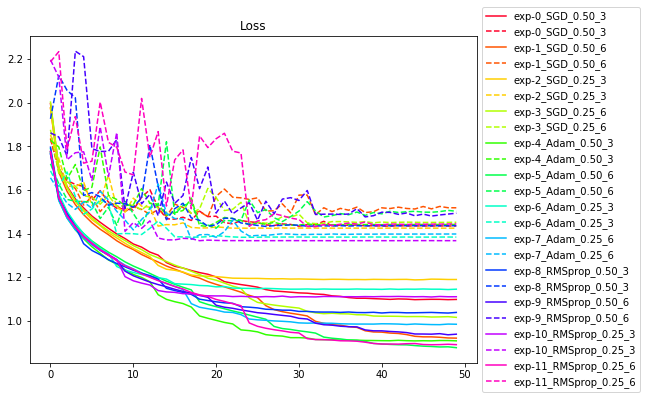

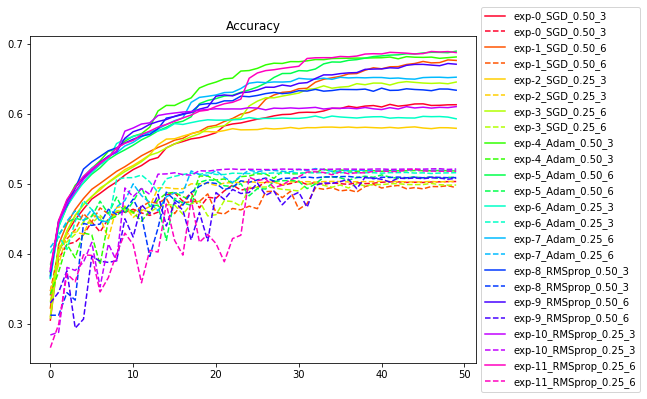

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()